In [1]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Verdana']
rcParams['font.size'] = 12
rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import phoebe
from matplotlib.ticker import FormatStrFormatter

cs = {'blue': '#2b71b1', 'orange': '#ff702f', 'green': '#22b77f', 'red': '#f92e3d', 'black': '#131313'}

In [18]:
def bundle_get_params_lc(filename, params_list, model_tag, true=False):
    b = phoebe.load('data/'+filename+'.bundle')
    if true:
        b.add_constraint('requivsumfrac')
        b.add_constraint('requivratio')
        b.add_constraint('teffratio')
        b.flip_constraint('teffratio', solve_for='teff@secondary')
        b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')
        b.flip_constraint('requivratio', solve_for='requiv@primary')
        b.flip_constraint('esinw', solve_for='ecc')
        b.flip_constraint('ecosw', solve_for='per0')
        b.flip_constraint('q', solve_for='mass@secondary')
        
    params = {}
    
    for param in params_list:
        params[param] = b.get_value(param+'@component')
    
    phases = b.to_phase(b['times@dataset@lc01'])
    fluxes = b['value@fluxes@%s@lc01' % model_tag]
    s=np.argsort(phases)
    
    lc = np.array([phases[s], fluxes[s]]).T
    if true:
        chi2 = np.nan
    else:
        residuals = b.calculate_residuals(model=model_tag)
        sigmas = b.get_value('sigmas', dataset='lc01')
        chi2 = np.sum((residuals.value**2 / sigmas))

    return {'solution': params, 'lc': lc, 'chi2': chi2}

def compute_y(solution, true, param):
    return 100*np.abs((solution['solution'][param]-true['solution'][param])/(true['solution'][param]))


def plot_solution(ax, title, labels, params, true, opt_right, opt_wrong, ylabel=False):
    
    s=50
    
    xs = np.arange(1, len(labels)+1, 1).astype(int)
    scatter_dict = {'x': [], 'y': [], 'fc': [], 'ec': [], 's': [], }

    for i,x in enumerate(xs):
        scatter_dict['x'] += [x, x]
        scatter_dict['fc'] += [cs['black'], cs['red']]
        scatter_dict['ec'] += [cs['black'], cs['red']]
        scatter_dict['y'] += [compute_y(opt_right, true, params[i]),
                              compute_y(opt_wrong, true, params[i])]                     
        scatter_dict['s'] += [s*opt_right['chi2'],
                              s*opt_wrong['chi2']]
                              
        
    ax.scatter(scatter_dict['x'][0], scatter_dict['y'][0], marker='o', 
           s=scatter_dict['s'][0], 
           facecolors=scatter_dict['fc'][0],
           edgecolors=scatter_dict['ec'][0], label='$T_1$, $a$ true for system')
    ax.scatter(scatter_dict['x'][1], scatter_dict['y'][1], marker='o', 
           s=scatter_dict['s'][1], 
           facecolors=scatter_dict['fc'][1],
#            edgecolors=scatter_dict['ec'][1], label='$T_1$, $a$ at PHOEBE defaults')
           edgecolors=scatter_dict['ec'][1], label='optimized for $T_1$, $a$')
        
        
    ax.scatter(scatter_dict['x'], scatter_dict['y'], marker='o', 
       s=scatter_dict['s'], 
       facecolors=scatter_dict['fc'],
       edgecolors=scatter_dict['ec'])      

    ax.margins(0.2)
    ax.grid(linestyle=':', linewidth='0.5', color='#131313', alpha=0.75)
    for gl in ax.get_xgridlines():
        gl.set_color(cs['black'])
        gl.set_linewidth(1)
        gl.set_linestyle('--')
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.set_title(title) 
    return ax, scatter_dict


def plot_lc(ax, true, opt_right, opt_wrong):
    ax.plot(true['lc'][:,0], true['lc'][:,1], '.', ms=10, alpha=0.5, c='gray')
    ax.plot(opt_right['lc'][:,0], opt_right['lc'][:,1], '-', lw=2, alpha=0.75, c=cs['black'])
    ax.plot(opt_wrong['lc'][:,0], opt_wrong['lc'][:,1], '--', c=cs['red'])
#     ax.set_xlabel(r'Orbital phase')
    ax.set_ylabel(r'Flux $[W/m^2]$')

In [7]:
# we_right = bundle_get_params_lc('we_nm_full', 
#                                  ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
#                                 'opt_full_model')
# we_wrong = bundle_get_params_lc('we_nm_wrong_full', 
#                                  ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
#                                 'opt_full_model')
ce_right = bundle_get_params_lc('ce_nm_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw',
                                 'teff@primary', 'sma@binary', 'q'],
                                'opt_full_model')
ce_wrong = bundle_get_params_lc('ce_nm_wrong_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw',
                                 'teff@primary', 'sma@binary', 'q'],
                                'opt_full_model')
ce_wrong_opt = bundle_get_params_lc('ce_nm_wrong_optimizeall', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw', 
                                  'teff@primary', 'sma@binary', 'q'],
                                'opt_full_model')
# we_true = bundle_get_params_lc('d_we', 
#                                  ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
#                                 'latest', true=True)
ce_true = bundle_get_params_lc('d_ce', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw',
                                 'teff@primary', 'sma@binary', 'q'],
                                'latest', true=True)

In [13]:
#ce_wrong_opt

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


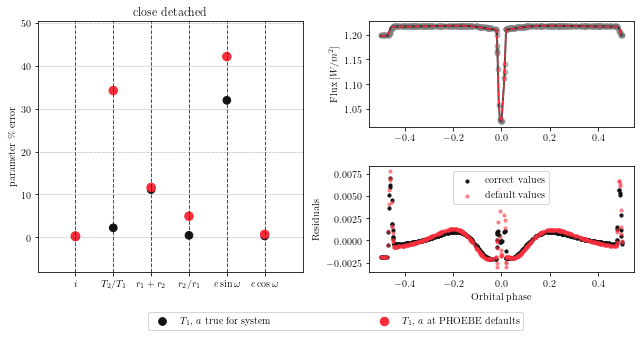

In [9]:
fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(5, 6)
ax1 = fig.add_subplot(gs[0:4, 0:3])
ax2 = fig.add_subplot(gs[0:2, 3:6])
ax3 = fig.add_subplot(gs[2:4, 3:6])
# ax4 = fig.add_subplot(gs[3:6, 3:6])
ax5 = fig.add_subplot(gs[4,1:5])


# scatter1, d1 = plot_solution(ax1, 'wide orbit', 
#             ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$'], 
#             ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'],
#             we_true, we_right, we_wrong, ylabel=True)
scatter2, d2 = plot_solution(ax1, 'close detached', 
            ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$'], 
            ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'],
            ce_true, ce_right, ce_wrong, ylabel=True)

# plot_lc(ax3, we_true, we_right, we_wrong)
plot_lc(ax2, ce_true, ce_right, ce_wrong)

ax3.scatter(ce_true['lc'][:,0], ce_right['lc'][:,1]-ce_true['lc'][:,1], marker='o', 
           s=10, 
           facecolors=cs['black'], edgecolors = cs['black'], label=r'correct values')
ax3.scatter(ce_true['lc'][:,0], ce_wrong['lc'][:,1]-ce_true['lc'][:,1], marker='o', 
           s=10, 
           facecolors=cs['red'], edgecolors = cs['red'], alpha=0.5, label=r'default values')
ax3.legend()
ax3.set_xlabel('Orbital phase')
ax3.set_ylabel('Residuals')

# ax1.set_ylim(-10,140)
# ax2.set_ylim(-10,80)
ax1.set_ylabel('parameter \% error')
# ax2.set_ylabel('parameter \% error')

h1, l1 = ax1.get_legend_handles_labels()

ax5.legend(h1[:2],l1[:2], borderaxespad=0, mode='expand', ncol=2)
ax5.axis("off")


# gs.tight_layout(fig)
fig.tight_layout()
# fig.savefig('figs/opimizing_strategies_methods.pdf')
fig.savefig('figs/opt_wrongteff.png', dpi=300)
plt.show()

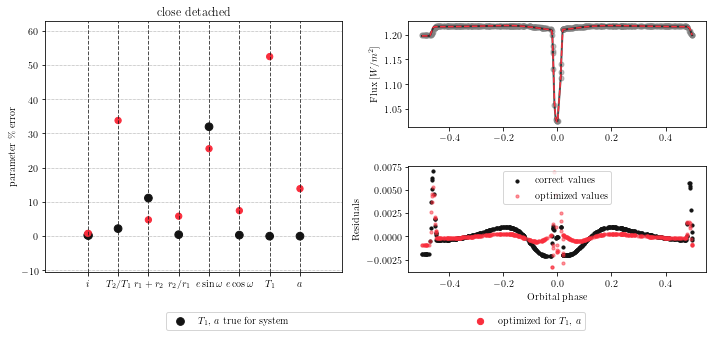

In [20]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(5, 6)
ax1 = fig.add_subplot(gs[0:4, 0:3])
ax2 = fig.add_subplot(gs[0:2, 3:6])
ax3 = fig.add_subplot(gs[2:4, 3:6])
# ax4 = fig.add_subplot(gs[3:6, 3:6])
ax5 = fig.add_subplot(gs[4,1:5])


# scatter1, d1 = plot_solution(ax1, 'wide orbit', 
#             ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$'], 
#             ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'],
#             we_true, we_right, we_wrong, ylabel=True)
scatter2, d2 = plot_solution(ax1, 'close detached', 
            ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$',
            '$T_1$', '$a$'], 
            ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw',
            'teff@primary', 'sma@binary'],
            ce_true, ce_right, ce_wrong_opt, ylabel=True)

# plot_lc(ax3, we_true, we_right, we_wrong)
plot_lc(ax2, ce_true, ce_right, ce_wrong)

ax3.scatter(ce_true['lc'][:,0], ce_right['lc'][:,1]-ce_true['lc'][:,1], marker='o', 
           s=10, 
           facecolors=cs['black'], edgecolors = cs['black'], label=r'correct values')
ax3.scatter(ce_true['lc'][:,0], ce_wrong_opt['lc'][:,1]-ce_true['lc'][:,1], marker='o', 
           s=10, 
           facecolors=cs['red'], edgecolors = cs['red'], alpha=0.5, label=r'optimized values')
ax3.legend()
ax3.set_xlabel('Orbital phase')
ax3.set_ylabel('Residuals')

# ax1.set_ylim(-10,140)
# ax2.set_ylim(-10,80)
ax1.set_ylabel('parameter \% error')
# ax2.set_ylabel('parameter \% error')

h1, l1 = ax1.get_legend_handles_labels()

ax5.legend(h1[:2],l1[:2], borderaxespad=0, mode='expand', ncol=2)
ax5.axis("off")


# gs.tight_layout(fig)
fig.tight_layout()
# fig.savefig('figs/opimizing_strategies_methods.pdf')
fig.savefig('figs/opt_wrongteff_allfit.png', dpi=300)
plt.show()